In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import random
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
import numpy
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.stats import mode
from sklearn.metrics import cohen_kappa_score, adjusted_rand_score, adjusted_mutual_info_score
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer

In [44]:
nltk.download('gutenberg')
nltk.download('punkt')
books = ['austen-emma.txt', 'bible-kjv.txt', 'bryant-stories.txt', 'melville-moby_dick.txt', 'edgeworth-parents.txt',
             'chesterton-thursday.txt', 'milton-paradise.txt']


def preprocess():
    print("Preprocessing Started.")
    # Select seven books

    document_word = {}
    document_sent = {}
# 
    count = 0

    for i in books:
        text = nltk.corpus.gutenberg.raw(i)

        count += 1

        # Transfer to lower characters
        text = text.lower()

        # Get the author name
        author = i.split('-')[0]

        # print(author)

        # Tokenize sentences
        sent_tokens = sent_tokenize(text)

        # Shuffle sentences
        random.shuffle(sent_tokens)

        full_sent = ''
        # Append to a list
        for j in range(len(sent_tokens)):
            full_sent = full_sent + sent_tokens[j]

        # Remove all the punctuations and change to word list
        tokenizer = RegexpTokenizer(r'\w+')
        words_tokens = tokenizer.tokenize(full_sent)

        for k in range(200):
            key = " ".join(words_tokens[k * 200:k * 200 + 199])
            value = author
            document_sent[key] = value
    print("Preprocessing Finished.")
    return(document_sent)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def doc2vec(docs, model=1):
  '''This function is to do Doc2Vec transformation.
  Args:
    docs: list of documents(if it has already tokenize, then do not need to do tokenize)
    model-1: if it is the first time to train the model, then do the training and save model
       -0: else load the pre-trained model

    max_epochs: The epochs to train model(small data 20-40 times)
    vec_size: The size of the vector to represent a document
    alpha: training momentum

  
  Return:
    infered_vectors_list: a (1400*vec_size) vector to represent all 1400 documents

    '''
  
  print("Doc2Vec Model training......")
  # Generate a TaggedDocument type variable, words are list of words in document, tags are number or the author
  tagged_data = [TaggedDocument(word_tokenize(doc), [i]) for i, doc in enumerate(docs)]

  max_epochs = 60
  vec_size = 50
  alpha = 0.025

  # Train Doc2Vec model
  # If it is the first time to create the model
  if model==1 :
    model = Doc2Vec(size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=1,
                    dm =1)
      
    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        # print('iteration {0}'.format(epoch))
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("d2v.model")
    print("Doc2Vec Model training finished.")
    print("Model Saved.")

  else:
    path = "d2v.model"
    model = Doc2Vec.load(path)

  # get the vector of each document by trained model
  infered_vectors_list=[]
  for text,label in tagged_data:
    vector=model.infer_vector(text)
    infered_vectors_list.append(vector)
  
  # print(infered_vectors_list)
  return infered_vectors_list


In [0]:
# kmeans
def kmeans(infered_vectors_list):
  km = KMeans(n_clusters=7)
  km.fit(infered_vectors_list)
  km_labels = km.labels_
  
  pred_label_kmeans = numpy.array([None]*1400)

  for i in range(7):
    cat = (km_labels == i)
    pred_label_kmeans[cat] = mode(true_labels[cat])[0]


  return pred_label_kmeans

In [0]:
def em(infered_vectors_list):
  # General EM for GMM
  # transform data such that the distribution mean = 0 and std = 1
  scaler = preprocessing.StandardScaler()
  scaler.fit(infered_vectors_list)
  data = scaler.transform(infered_vectors_list)

  em_labels =  GaussianMixture(n_components=7)          
  em_labels = em_labels.fit_predict(infered_vectors_list)

  pred_label_em = numpy.array([None]*1400)

  for i in range(7):
    cat = (em_labels == i)
    pred_label_em[cat] = mode(true_labels[cat])[0]
  return pred_label_em

In [0]:
def agg(infered_vectors_list):
  agg_labels =  AgglomerativeClustering(n_clusters=7)          
  agg_labels = agg_labels.fit_predict(infered_vectors_list)

  pred_label_agg = numpy.array([None]*1400)

  for i in range(7):
    cat = (agg_labels == i)
    pred_label_agg[cat] = mode(true_labels[cat])[0]
  return pred_label_agg

In [0]:
def kappa(pred_label_kmeans, pred_label_em, pred_label_agg, true_labels):
  ''' Kappa '''
  # print("Kappa")
  kappa_km = cohen_kappa_score(pred_label_kmeans, true_labels)
  kappa_em = cohen_kappa_score(pred_label_em, true_labels)
  kappa_agg = cohen_kappa_score(pred_label_agg, true_labels)
  kappa_3 = cohen_kappa_score(pred_label_kmeans, pred_label_em, pred_label_agg)
  # print("Agreement between k-means cluster and human labels: ",kappa_km)  #Perform evaluation on kmeans cluster with human labels
  # print("Agreement between EM cluster and human labels: ", kappa_em)  #Perform evaluation on hieratical cluster with human labels
  # print("Agreement between Agglomerative Clustering cluster and human labels: ",kappa_agg)
  # print("Agreement between K-means, EM and AgglomerativeClustering:", kappa_3)  #Perform evaluation on kmeans cluster with hieratical
  return [kappa_km, kappa_em, kappa_agg, kappa_3]


In [0]:
def silhouette(infered_vectors_list, pred_label_kmeans, pred_label_em, pred_label_agg):
  silhouette_score_km = metrics.silhouette_score(infered_vectors_list, pred_label_kmeans, metric='euclidean')
  print ("Silhouette_score of K-means: ", silhouette_score_km)
  silhouette_score_em = metrics.silhouette_score(infered_vectors_list, pred_label_em, metric='euclidean')
  print ("Silhouette_score of EM: ", silhouette_score_em)
  silhouette_score_agg = metrics.silhouette_score(infered_vectors_list, pred_label_agg, metric='euclidean')
  print ("Silhouette_score of Agglomerative Clustering: ", silhouette_score_agg)

Preprocessing Started.
Preprocessing Finished.
Doc2Vec Model training......


/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Doc2Vec Model training finished.
Model Saved.
Silhouette_score of K-means:  0.08284257
Silhouette_score of EM:  0.06948782
Silhouette_score of Agglomerative Clustering:  0.072991736


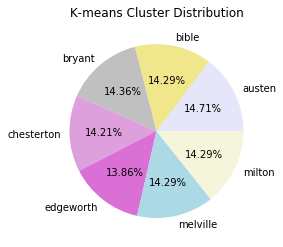

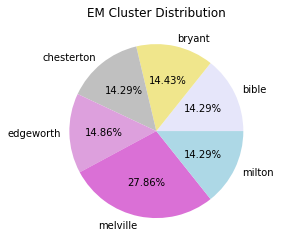

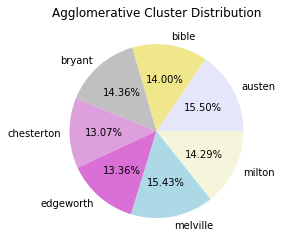

Mean of Kappa of K-means against human labels:  0.9924999999999999
Mean of Kappa of EM against human labels:  0.9544444444444444
Mean of Kappa of Agglomerative against human labels:  0.9149999999999999
Mean of Kappa of three clustering algorithms:  0.9608324715172031
[0.9925     0.95444444 0.915      0.96083247]


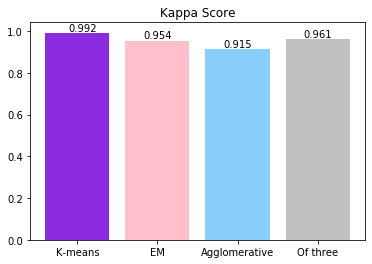

In [51]:
# The main part, run this part to call functions and get result

# Do preprocessing
document_sent = preprocess()

# get all the documents
docs = list(document_sent.keys())

# shuffle documents
random.shuffle(docs)

# get true labels of documents
true_labels = []

for i in docs:
  true_labels.append(document_sent[i])

true_labels = numpy.array(true_labels)
true_labels = true_labels.T

# do doc2vec transform, the first argument is the document, 
# the second one is if you need to train the model(1:train, 0:load the old model)
infered_vectors_list = doc2vec(docs)

kappa_score = numpy.zeros([11, 4])
for i in range(10):
  pred_label_kmeans = kmeans(infered_vectors_list)
  pred_label_em = em(infered_vectors_list)
  pred_label_agg = agg(infered_vectors_list)
  kappa_score[i] = kappa(pred_label_kmeans, pred_label_em, pred_label_agg, true_labels)

silhouette(infered_vectors_list, pred_label_kmeans, pred_label_em, pred_label_agg)

# Draw three distribution pies
unique, counts = numpy.unique(pred_label_kmeans, return_counts=True)
# print("The clustering distribution of K-means: ", dict(zip(unique, counts)))
colors = ['lavender', 'khaki','silver', 'plum', 'orchid', 'lightblue', 'beige']
plt.pie(counts,labels=unique,autopct='%1.2f%%', colors=colors) 
plt.title("K-means Cluster Distribution") 
plt.show()

unique, counts = numpy.unique(pred_label_em, return_counts=True)
# print("The clustering distribution of K-means: ", dict(zip(unique, counts)))
colors = ['lavender', 'khaki','silver', 'plum', 'orchid', 'lightblue', 'beige']
plt.pie(counts,labels=unique,autopct='%1.2f%%', colors=colors) 
plt.title("EM Cluster Distribution") 
plt.show()

unique, counts = numpy.unique(pred_label_agg, return_counts=True)
# print("The clustering distribution of K-means: ", dict(zip(unique, counts)))
colors = ['lavender', 'khaki','silver', 'plum', 'orchid', 'lightblue', 'beige']
plt.pie(counts,labels=unique,autopct='%1.2f%%', colors=colors) 
plt.title("Agglomerative Cluster Distribution") 
plt.show()

# Calculate the mean of Kappa and draw a bar figure
import statistics 
kappa_score[10] = numpy.mean(kappa_score[0:9], axis=0)

print("Mean of Kappa of K-means against human labels: ", kappa_score[10][0])
print("Mean of Kappa of EM against human labels: ", kappa_score[10][1])
print("Mean of Kappa of Agglomerative against human labels: ", kappa_score[10][2])
print("Mean of Kappa of three clustering algorithms: ", kappa_score[10][3])

s = [kappa_score[10]]
print(s[0])
n = ['K-means', 'EM', 'Agglomerative', 'Of three']
c = ['blueviolet', 'pink', 'lightskyblue', 'silver']
a = [0.07,1,2, 3]
plt.bar(n, s[0], color=c)
for a,b in zip(a,s[0]):
  plt.text(a, b, '%.3f' % b, ha='center', va= 'bottom',fontsize=10)
  plt.title("Kappa Score")
plt.show()

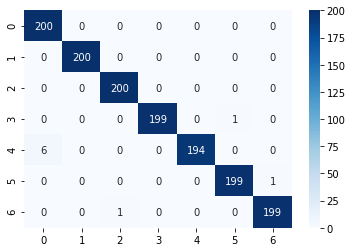

In [61]:
from sklearn.metrics import confusion_matrix

y_true = true_labels
y_pred = pred_label_kmeans
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True,fmt='.20g', cmap='Blues')